# Image Captioning

In this Notebook you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Setup Google Colab

Downloads scripts and data

In [0]:
%env EXPERIMENTAL_TQDM=1

env: EXPERIMENTAL_TQDM=1


In [0]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week6()

--2018-12-12 17:28:50--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2018-12-12 17:28:50 (58.0 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]



# Import stuff

In [0]:
import sys
sys.path.append("..")
import grading
import download_utils

In [0]:
download_utils.link_all_keras_resources()

In [0]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils

Using TensorFlow backend.


# Prepare the storage for model checkpoints

You will need a Google account!

In [0]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab17"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weight")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weight_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab17/weight_10


# Link data

Takes 10 hours and 20 GB. We've already downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [0]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/inceptionv3.png?raw=1" style="width:70%">

In [0]:
IMG_SIZE = 299

In [0]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [0]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [0]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

# Extract captions for images

In [0]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


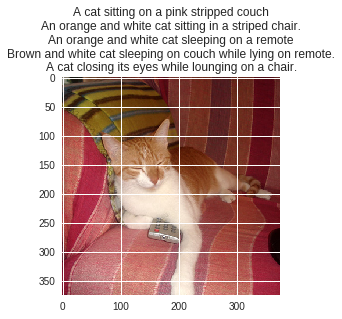

In [0]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [0]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [0]:
from collections import Counter 
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    num_of_img = len(train_captions)
    train_caption = train_captions
    
    token_list = []
    for i in range(len(train_caption)):
      
      el_train_captions = train_caption[i]
      
      for j in range(len(el_train_captions)):
        token_list.append(split_sentence(el_train_captions[j]))
        
    flattened = [val for sublist in token_list for val in sublist]
    
    num_of_rep = Counter(flattened)
    
    vocab = list(set(flattened))
    
    for i in  range(len(vocab)):
      
      word = vocab[i]
        
      if num_of_rep[word] < 5:
          vocab[i] = 'zxy'
      
          
    vocab.append(PAD)
    vocab.append(UNK)
    vocab.append(START)
    vocab.append(END)
      
#     return vocab
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab): 
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    
    token_list = []
    for i in range(len(captions)):
          
        img_list = []
        el_train_captions = captions[i]

        for j in range(len(el_train_captions)):
            
          img_list.append(split_sentence(el_train_captions[j]))
            
        token_list.append(img_list)

    

    for p in range(len(token_list)):
      
      for v in range(len(token_list[p])):
        
          for q in range(len(token_list[p][v])):

            if q == 0:
              token_list[p][v].insert(0, vocab.get("#START#"))
              token_list[p][v].append(vocab.get("#END#"))


            key = token_list[p][v][q+1]
            ind = vocab.get(key)

            if ind == None:

              token_list[p][v][q+1] = vocab.get("#UNK#")

            if ind != None:

              token_list[p][v][q+1] = ind

    return token_list

In [0]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
del vocab['zxy']
print(len(vocab))

8769


In [0]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [0]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    matrix = []
    
    for caption in batch_captions:
        
        if max_len == None:
          
            columns =  max(map(len, batch_captions))
            
        else:
          
            columns = min(max_len, max(map(len, batch_captions)))
        
        if len(caption) >= columns:
          
            row = caption[0:columns]
            
        else:
          
            extra = columns - len(caption)
            row = caption + [pad_idx] * extra
            
        matrix.append(row)
        
    matrix = np.array(matrix, dtype = int)    
    
    return matrix

In [0]:
# make sure you use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/encoder_decoder_explained.png?raw=1" style="width:50%">

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/flatten_help.jpg?raw=1" style="width:80%">

**As an experiment, I add dropout layer to the network**

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
      
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    dropout_cell = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=0.8, variational_recurrent=True, input_size=LSTM_UNITS, dtype=tf.float32)
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states

    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,[-1, LSTM_UNITS])    
    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(pad_idx, flat_ground_truth)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# learning_rate = tf.placeholder('float32')

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# test random decoder loss, should get ~9
print(grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

9.079427


In [0]:
# look at the shapes, can help with debug
def print_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s):
    tensors_to_test = [
        decoder.h0,
        decoder.word_embeds,
        decoder.flat_hidden_states,
        decoder.flat_token_logits,
        decoder.flat_ground_truth,
        decoder.flat_loss_mask,
        decoder.loss
    ]
    all_shapes = []
    for t in tensors_to_test:
        _ = s.run(t, feed_dict=grading_utils.get_feed_dict_for_testing(decoder, IMG_EMBED_SIZE, vocab))
        print("{}: {}".format(t.name, _.shape))
        
print_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s)

dense_1/Elu:0: (32, 300)
embedding/embedding_lookup/Identity_2:0: (32, 19, 100)
Reshape:0: (608, 300)
dense_3/BiasAdd:0: (608, 8769)
Reshape_1:0: (608,)
NotEqual:0: (608,)
Mean:0: ()


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    random_idx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings = images_embeddings[random_idx_batch]

    batch_captions_matrix = [caption[np.random.randint(5)] for caption in indexed_captions[random_idx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 64
n_epochs = 36
n_batches_per_epoch = 1000
n_validation_batches = 100 # how many batches are used for validation after each epoch

In [0]:
# you can load trained weights here
# uncomment the next line if you need to load weights
# saver.restore(s, get_checkpoint_path(epoch=123))

Look at the training and validation loss, they should be decreasing!

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Open http://9b3f3d6d.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")


Epoch: 0, train loss: 4.2593325152397155, val loss: 3.624335808753967



Epoch: 1, train loss: 3.3131638469696045, val loss: 3.110921199321747



Epoch: 2, train loss: 2.9971298339366914, val loss: 2.9477942991256714



Epoch: 3, train loss: 2.8431083393096923, val loss: 2.8473867917060853



Epoch: 4, train loss: 2.7573515043258667, val loss: 2.786004297733307



Epoch: 5, train loss: 2.6940451917648316, val loss: 2.7341389775276186



Epoch: 6, train loss: 2.636907073020935, val loss: 2.692437160015106



Epoch: 7, train loss: 2.594092498540878, val loss: 2.6696837186813354



Epoch: 8, train loss: 2.5627936718463897, val loss: 2.619591600894928



Epoch: 9, train loss: 2.5274514508247377, val loss: 2.615569858551025



Epoch: 10, train loss: 2.500629826307297, val loss: 2.602014539241791



Epoch: 11, train loss: 2.480323005437851, val loss: 2.5924838018417358



Epoch: 12, train loss: 2.4618594975471497, val loss: 2.584866147041321



Epoch: 13, train loss: 2.4453651723861696, val loss: 2.571006293296814



Epoch: 14, train loss: 2.4271162626743314, val loss: 2.5729417824745178



Epoch: 15, train loss: 2.4123431205749513, val loss: 2.546386857032776



Epoch: 16, train loss: 2.4025497617721556, val loss: 2.5520238709449767



Epoch: 17, train loss: 2.3806661523580552, val loss: 2.5467711424827577



Epoch: 18, train loss: 2.369480756521225, val loss: 2.4963034772872925



Epoch: 19, train loss: 2.366973738193512, val loss: 2.530790545940399



Epoch: 20, train loss: 2.3493336279392243, val loss: 2.5129469776153566



Epoch: 21, train loss: 2.349410633802414, val loss: 2.5049512600898742



Epoch: 22, train loss: 2.328915202856064, val loss: 2.5040624284744264



Epoch: 23, train loss: 2.3209448382854463, val loss: 2.511068880558014



Epoch: 24, train loss: 2.3127889964580537, val loss: 2.4963052320480346



Epoch: 25, train loss: 2.306212969183922, val loss: 2.49460262298584



Epoch: 26, train loss: 2.3002695068120955, val loss: 2.5024776577949526



Epoch: 27, train loss: 2.291809397339821, val loss: 2.491542456150055



Epoch: 28, train loss: 2.2874738451242447, val loss: 2.5140158581733703



Epoch: 29, train loss: 2.2771019369363783, val loss: 2.515589265823364



Epoch: 30, train loss: 2.2679331494569777, val loss: 2.4702838110923766



Epoch: 31, train loss: 2.2723674817085264, val loss: 2.485527238845825



Epoch: 32, train loss: 2.261947372913361, val loss: 2.4793411469459534



Epoch: 33, train loss: 2.2487437599897384, val loss: 2.4845973229408265



Epoch: 34, train loss: 2.2501989035606385, val loss: 2.489785394668579



Epoch: 35, train loss: 2.2425760461091997, val loss: 2.4763631200790406
Finished!


In [0]:
# Validation loss, you should go below ~2.5
print(grading_utils.test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed))


2.4862703654766083


In [0]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.288672
Accuracy: 0.5223097112860893
Example 0
Predicted: a man and wine from a as a #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man pouring wine from #UNK# for patrons #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man in to a bicycle with on #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man tries out a bicycle powered blender #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Pre

In [0]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/gdrive/My Drive/colab17/weight'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [0]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/colab17/weight


In [0]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [0]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player holding a bat on a field


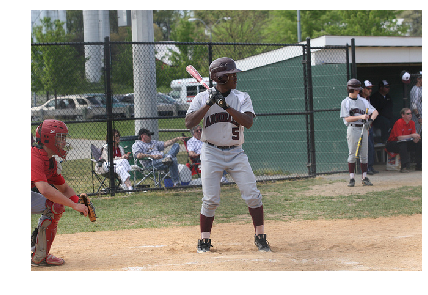

In [0]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a man holding a toothbrush in his hand


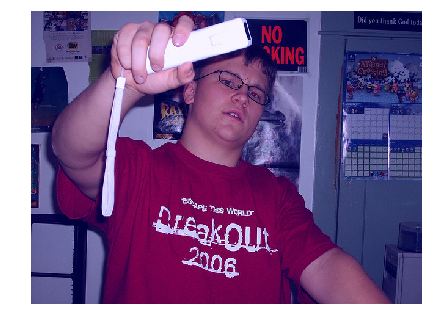

a group of sheep standing next to each other


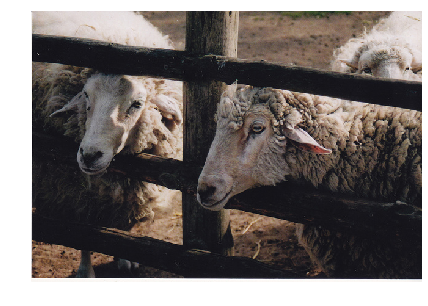

a street sign sitting on the side of a road


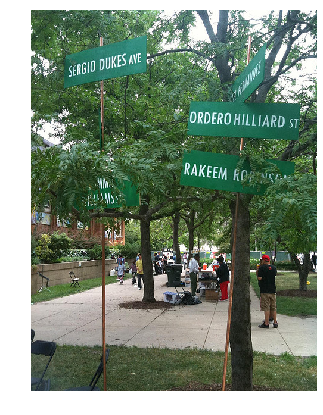

a bowl of fruit is sitting on a table


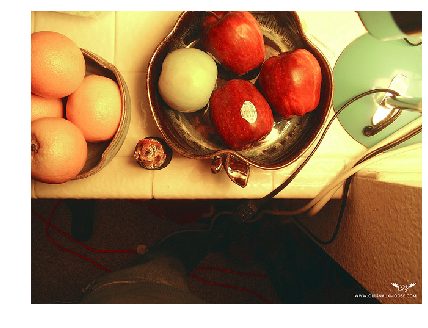

a group of men standing next to each other on a field


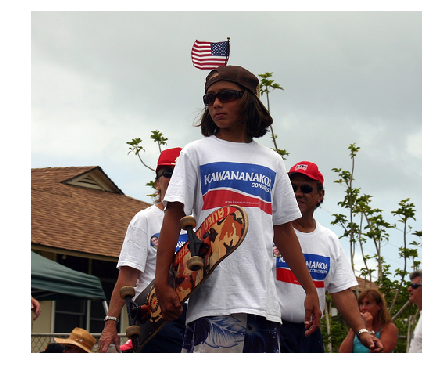

a kitchen with a stove and a stove


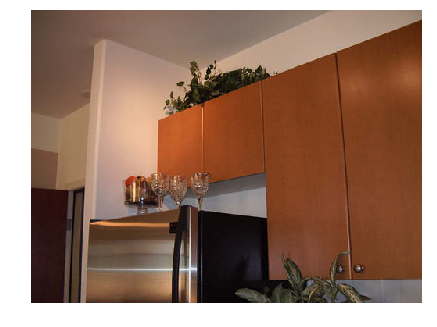

a double decker bus is parked in a parking lot


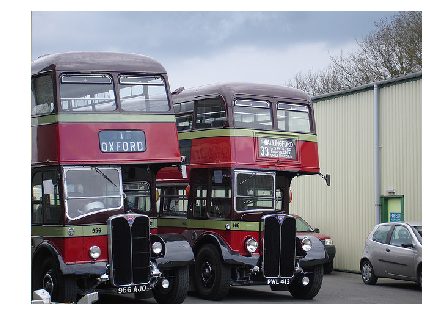

a living room with a couch and a table


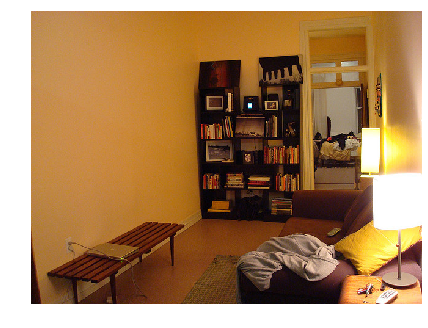

a bicycle parked in front of a building


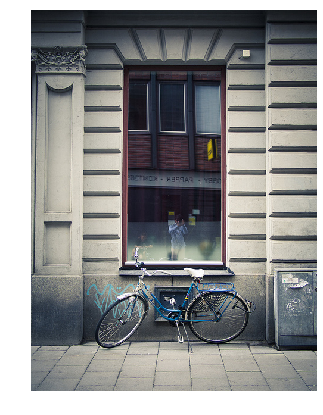

a woman in a white dress playing tennis


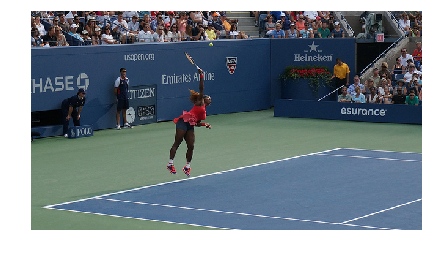

In [0]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

You can download any image from the Internet and appply your model to it!

In [0]:
download_utils.download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)

a cake with a fondant cake on top of it


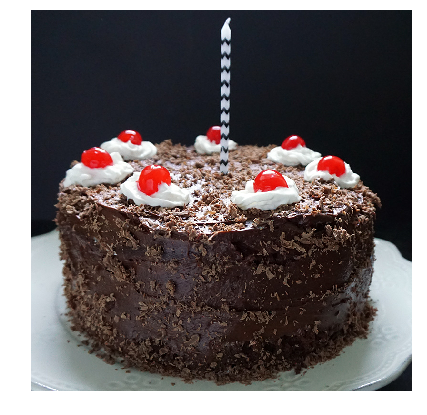

In [0]:
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Now it's time to find 10 examples where your model works good and 10 examples where it fails! 

You can use images from validation set as follows:
```python
show_valid_example(val_img_fns, example_idx=...)
```

You can use images from the Internet as follows:
```python
! wget ...
apply_model_to_image_raw_bytes(open("...", "rb").read())
```

If you use these functions, the output will be embedded into your notebook and will be visible during peer review!

When you're done, download your noteboook using "File" -> "Download as" -> "Notebook" and prepare that file for peer review!

In [0]:
download_utils.download_file(
    'https://st2.depositphotos.com/1062321/10401/i/950/depositphotos_104012608-stock-photo-old-bike-on-the-street.jpg',
    "bike1.jpg"
)
download_utils.download_file(
    'https://kuda-spb.ru/uploads/f8da4cbc3f849d5fbfd5e9c975576614.jpg',
    "cat1.jpg"
)
download_utils.download_file(
    'http://www.vsluh.ru/uploads/base_image/image/58374/huge_5087e170-bb25-4f67-9f95-26bf38126a87.jpg',
    "bus1.jpg"
)
download_utils.download_file(
    'https://metrosexual.com.ua/wp-content/uploads/2016/05/10_Luk1-min.jpg',
    "man1.jpg"
)
download_utils.download_file(
    'http://ladyzest.com/wordpress/wp-content/uploads/2014/05/578.jpg',
    "man2.jpg"
)
download_utils.download_file(
    'http://wnature.net/pictures/2016/02/2927/labrador-lezhit-na-zelenoy-trave.jpg',
    "dog3.jpg"
)
download_utils.download_file(
    'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Football_iu_1996.jpg/1200px-Football_iu_1996.jpg',
    "foot.jpg"
)
download_utils.download_file(
    'https://icdn.lenta.ru/images/2017/12/28/14/20171228142421311/detail_1fafc3fb3dbb5341826d57df873ceed4.jpg',
    "boxing.jpg"
)
download_utils.download_file('https://i.ytimg.com/vi/iwnLS8PEhfU/maxresdefault.jpg',
                             "children.jpg"
)
download_utils.download_file('http://mestagugla.ru/wp-content/uploads/syria_damascus_7road3.jpg',
                             "city.jpg"
)
download_utils.download_file('http://www.crazyshark.ru/wp-content/uploads/2010/01/ded-moroz-01.jpg',
                             "ded_moroz.jpg"
)
download_utils.download_file('http://planpregnancy.ru/images/stories/2content/0410152.jpg',
                             "room.jpg"
)

**Examples of correct captioning (various starts of the notebook depicts different caption, that is why some captions are not so correct)**

a bicycle parked on the sidewalk next to a bike


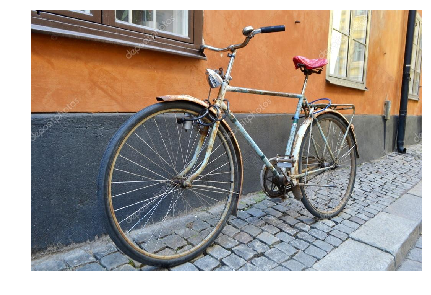

a group of people standing around each other


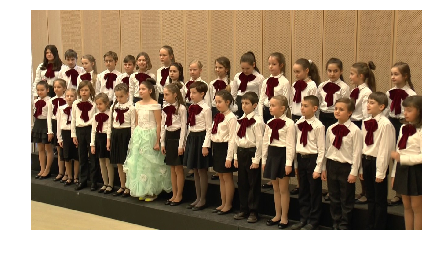

a kitchen with a white refrigerator freezer next to a wooden table


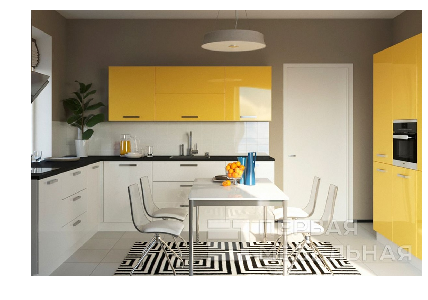

a living room with a couch and a television


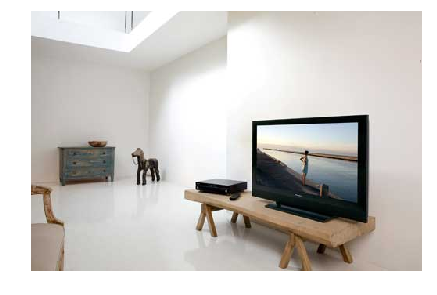

In [0]:
apply_model_to_image_raw_bytes(open("bike1.jpg", "rb").read())
apply_model_to_image_raw_bytes(open("children.jpg", "rb").read())
apply_model_to_image_raw_bytes(open("kitchen.jpg", "rb").read())
apply_model_to_image_raw_bytes(open("room.jpg", "rb").read())

**Examples of wrong captioning (the same situation as in previous section)**

a cat is sitting on a chair with a book


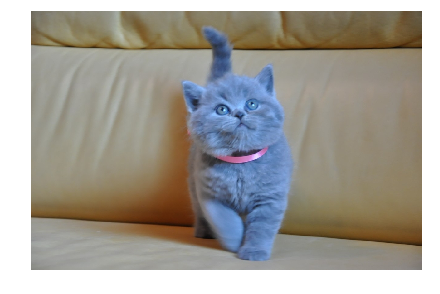

a man in a blue shirt holding a tennis racket


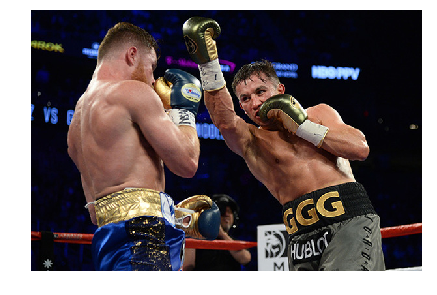

a large white vase with a large white vase


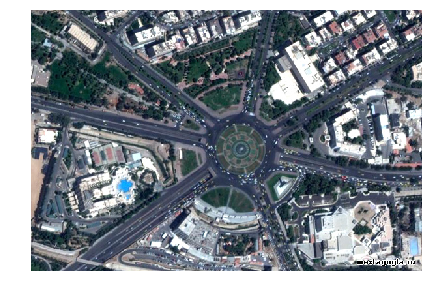

a teddy bear with a bow tie and a hat


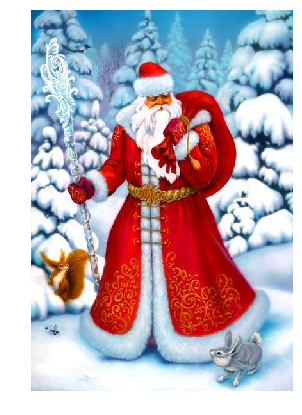

In [0]:
apply_model_to_image_raw_bytes(open("cat1.jpg", "rb").read())
apply_model_to_image_raw_bytes(open("boxing.jpg", "rb").read())
apply_model_to_image_raw_bytes(open("city.jpg", "rb").read())
apply_model_to_image_raw_bytes(open("ded_moroz.jpg", "rb").read())

That's it! 

Congratulations, you've trained your image captioning model and now can produce captions for any picture from the  Internet!

# Experiments

## Increasing a size of hidden state (for faster learning, in this case use 15 epochs)

### Models

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
      
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    dropout_cell = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=0.8, variational_recurrent=True, input_size=LSTM_UNITS, dtype=tf.float32)
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states

    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,[-1, LSTM_UNITS])    
    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(pad_idx, flat_ground_truth)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# learning_rate = tf.placeholder('float32')

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    random_idx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings = images_embeddings[random_idx_batch]

    batch_captions_matrix = [caption[np.random.randint(5)] for caption in indexed_captions[random_idx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 64
n_epochs = 15
n_batches_per_epoch = 1000
n_validation_batches = 100 # how many batches are used for validation after each epoch

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Open http://9b3f3d6d.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

training_loss = []
validation_loss = []

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    training_loss.append(train_loss)
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    validation_loss.append(val_loss)
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")


Epoch: 0, train loss: 4.27230331325531, val loss: 3.6652807927131654



Epoch: 1, train loss: 3.3130492510795593, val loss: 3.1059197545051576



Epoch: 2, train loss: 2.996950412273407, val loss: 2.9453628420829774



Epoch: 3, train loss: 2.8437500817775727, val loss: 2.849464704990387



Epoch: 4, train loss: 2.7585237143039705, val loss: 2.7856633853912354



Epoch: 5, train loss: 2.694715569257736, val loss: 2.729867639541626



Epoch: 6, train loss: 2.637931971788406, val loss: 2.6949881982803343



Epoch: 7, train loss: 2.5954809143543245, val loss: 2.6726827788352967



Epoch: 8, train loss: 2.5647122130393982, val loss: 2.6238661098480223



Epoch: 9, train loss: 2.529763402700424, val loss: 2.6188828563690185



Epoch: 10, train loss: 2.5026308312416075, val loss: 2.599551501274109



Epoch: 11, train loss: 2.4825935525894165, val loss: 2.591321051120758



Epoch: 12, train loss: 2.4631961011886596, val loss: 2.5823775005340575



Epoch: 13, train loss: 2.447046195268631, val loss: 2.5707089495658875



Epoch: 14, train loss: 2.4268411679267885, val loss: 2.5738376784324646
Finished!


In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 512
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
      
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    dropout_cell = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=0.8, variational_recurrent=True, input_size=LSTM_UNITS, dtype=tf.float32)
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states

    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,[-1, LSTM_UNITS])    
    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(pad_idx, flat_ground_truth)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# learning_rate = tf.placeholder('float32')

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    random_idx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings = images_embeddings[random_idx_batch]

    batch_captions_matrix = [caption[np.random.randint(5)] for caption in indexed_captions[random_idx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 64
n_epochs = 15
n_batches_per_epoch = 1000
n_validation_batches = 100 # how many batches are used for validation after each epoch

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Open http://9b3f3d6d.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

training_loss1 = []
validation_loss1 = []


for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    training_loss1.append(train_loss)
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    validation_loss1.append(val_loss)
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")


Epoch: 0, train loss: 4.204415483236313, val loss: 3.593214445114136



Epoch: 1, train loss: 3.2681449239253997, val loss: 3.0797439312934873



Epoch: 2, train loss: 2.9707205903530123, val loss: 2.920796601772308



Epoch: 3, train loss: 2.821300860404968, val loss: 2.833138115406036



Epoch: 4, train loss: 2.737519764661789, val loss: 2.7725682616233827



Epoch: 5, train loss: 2.6760861978530883, val loss: 2.7190877294540403



Epoch: 6, train loss: 2.61923517870903, val loss: 2.683267979621887



Epoch: 7, train loss: 2.5781443648338316, val loss: 2.6567207860946653



Epoch: 8, train loss: 2.5461983437538147, val loss: 2.602853195667267



Epoch: 9, train loss: 2.5127127046585085, val loss: 2.6124456119537354



Epoch: 10, train loss: 2.4862291707992554, val loss: 2.585923011302948



Epoch: 11, train loss: 2.4666957006454466, val loss: 2.5842975568771362



Epoch: 12, train loss: 2.4454783334732055, val loss: 2.579082109928131



Epoch: 13, train loss: 2.429159558415413, val loss: 2.5629827761650086



Epoch: 14, train loss: 2.411432265281677, val loss: 2.5672013664245608
Finished!


In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 1024
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
      
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    dropout_cell = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=0.8, variational_recurrent=True, input_size=LSTM_UNITS, dtype=tf.float32)
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states

    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,[-1, LSTM_UNITS])    
    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(pad_idx, flat_ground_truth)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# learning_rate = tf.placeholder('float32')

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    random_idx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings = images_embeddings[random_idx_batch]

    batch_captions_matrix = [caption[np.random.randint(5)] for caption in indexed_captions[random_idx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 64
n_epochs = 15
n_batches_per_epoch = 1000
n_validation_batches = 100 # how many batches are used for validation after each epoch

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Open http://9b3f3d6d.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

training_loss2 = []
validation_loss2 = []

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    training_loss2.append(train_loss)
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    validation_loss2.append(val_loss)
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")


Epoch: 0, train loss: 4.157105058193207, val loss: 3.4715546798706054



Epoch: 1, train loss: 3.1795509343147277, val loss: 3.029259595870972



Epoch: 2, train loss: 2.939105796337128, val loss: 2.906017336845398



Epoch: 3, train loss: 2.8040276701450346, val loss: 2.8242189192771914



Epoch: 4, train loss: 2.725563891172409, val loss: 2.773065149784088



Epoch: 5, train loss: 2.668558616399765, val loss: 2.7159626150131224



Epoch: 6, train loss: 2.612773763179779, val loss: 2.679846248626709



Epoch: 7, train loss: 2.570856360435486, val loss: 2.6588958716392517



Epoch: 8, train loss: 2.5426724646091463, val loss: 2.600997884273529



Epoch: 9, train loss: 2.5067257299423216, val loss: 2.6092108607292177



Epoch: 10, train loss: 2.478858479499817, val loss: 2.5900453186035155



Epoch: 11, train loss: 2.4591734209060667, val loss: 2.5818986916542053



Epoch: 12, train loss: 2.438816259384155, val loss: 2.5765417861938475



Epoch: 13, train loss: 2.4230827468633653, val loss: 2.5675608706474304



Epoch: 14, train loss: 2.403516991138458, val loss: 2.5703353691101074
Finished!


### Graphs

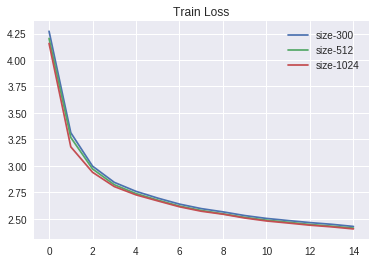

In [0]:
import matplotlib.pyplot as plt

x = np.arange(0,15)

plt.plot(x, training_loss, label='size-300')
plt.plot(x, training_loss1,label='size-512')
plt.plot(x, training_loss2, label='size-1024')
plt.legend()
plt.title('Train Loss')
plt.show()

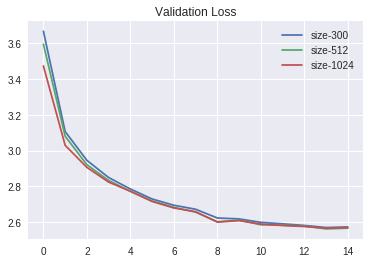

In [0]:
plt.plot(x, validation_loss, label='size-300')
plt.plot(x, validation_loss1,label='size-512')
plt.plot(x, validation_loss2, label='size-1024')
plt.legend()
plt.title('Validation Loss')
plt.show()

According to these graphs, increasing of size of hidden state imporve learning skills, after 15 epochs algorithm with more elements in hidden state can fix in one value of loss function and sometimes deviate from it.

## Increasing a size of batch

###  Models

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
      
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    dropout_cell = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=0.8, variational_recurrent=True, input_size=LSTM_UNITS, dtype=tf.float32)
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states

    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,[-1, LSTM_UNITS])    
    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(pad_idx, flat_ground_truth)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# learning_rate = tf.placeholder('float32')

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    random_idx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings = images_embeddings[random_idx_batch]

    batch_captions_matrix = [caption[np.random.randint(5)] for caption in indexed_captions[random_idx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 64
n_epochs = 15
n_batches_per_epoch = 1000
n_validation_batches = 100 # how many batches are used for validation after each epoch

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Open http://9b3f3d6d.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

training_loss = []
validation_loss = []

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    training_loss.append(train_loss)
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    validation_loss.append(val_loss)
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")


Epoch: 0, train loss: 4.265031056165695, val loss: 3.6441762900352477



Epoch: 1, train loss: 3.337983554363251, val loss: 3.12892343044281



Epoch: 2, train loss: 3.01352902507782, val loss: 2.952337110042572



Epoch: 3, train loss: 2.847948480606079, val loss: 2.8487266802787783



Epoch: 4, train loss: 2.7582163605690004, val loss: 2.7869763946533204



Epoch: 5, train loss: 2.694212359666824, val loss: 2.7310494327545167



Epoch: 6, train loss: 2.6360683810710905, val loss: 2.6931930661201475



Epoch: 7, train loss: 2.594890710353851, val loss: 2.6671664333343506



Epoch: 8, train loss: 2.563483211040497, val loss: 2.6176835036277772



Epoch: 9, train loss: 2.5275650675296784, val loss: 2.6180327916145325



Epoch: 10, train loss: 2.499397884130478, val loss: 2.597632987499237



Epoch: 11, train loss: 2.4799625470638276, val loss: 2.5924572730064392



Epoch: 12, train loss: 2.4620687599182127, val loss: 2.585413684844971



Epoch: 13, train loss: 2.4454444231987, val loss: 2.570121521949768



Epoch: 14, train loss: 2.4265442643165587, val loss: 2.567115800380707
Finished!


In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
      
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    dropout_cell = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=0.8, variational_recurrent=True, input_size=LSTM_UNITS, dtype=tf.float32)
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states

    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,[-1, LSTM_UNITS])    
    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(pad_idx, flat_ground_truth)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# learning_rate = tf.placeholder('float32')

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    random_idx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings = images_embeddings[random_idx_batch]

    batch_captions_matrix = [caption[np.random.randint(5)] for caption in indexed_captions[random_idx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 128
n_epochs = 15
n_batches_per_epoch = 1000
n_validation_batches = 100 # how many batches are used for validation after each epoch

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Open https://9b3f3d6d.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

training_loss1 = []
validation_loss1 = []


for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    training_loss1.append(train_loss)
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    validation_loss1.append(val_loss)
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")


Epoch: 0, train loss: 4.149782695055008, val loss: 3.4063151049613953



Epoch: 1, train loss: 3.103209982872009, val loss: 2.979738256931305



Epoch: 2, train loss: 2.844796916723251, val loss: 2.8222960114479063



Epoch: 3, train loss: 2.701984130620956, val loss: 2.7137155437469485



Epoch: 4, train loss: 2.6239508044719697, val loss: 2.6723716974258425



Epoch: 5, train loss: 2.5642490525245667, val loss: 2.6430844497680663



Epoch: 6, train loss: 2.517814517259598, val loss: 2.6048693466186523



Epoch: 7, train loss: 2.4822065541744234, val loss: 2.5701599884033204



Epoch: 8, train loss: 2.4447379953861237, val loss: 2.5672678899765016



Epoch: 9, train loss: 2.4163357689380645, val loss: 2.5527654552459715



Epoch: 10, train loss: 2.3983680403232572, val loss: 2.531187565326691



Epoch: 11, train loss: 2.3749876294136048, val loss: 2.5140249705314637



Epoch: 12, train loss: 2.3472689287662507, val loss: 2.497609786987305



Epoch: 13, train loss: 2.335280520915985, val loss: 2.5097090339660646



Epoch: 14, train loss: 2.3215834848880768, val loss: 2.493841617107391
Finished!


In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
      
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])
    
    dropout_cell = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=0.8, variational_recurrent=True, input_size=LSTM_UNITS, dtype=tf.float32)
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states

    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states,[-1, LSTM_UNITS])    
    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(pad_idx, flat_ground_truth)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# learning_rate = tf.placeholder('float32')

# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    random_idx_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace= False)
    batch_image_embeddings = images_embeddings[random_idx_batch]

    batch_captions_matrix = [caption[np.random.randint(5)] for caption in indexed_captions[random_idx_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions_matrix, pad_idx, max_len=max_len)
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 256
n_epochs = 15
n_batches_per_epoch = 1000
n_validation_batches = 100 # how many batches are used for validation after each epoch

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Open http://9b3f3d6d.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

training_loss2 = []
validation_loss2 = []

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    training_loss2.append(train_loss)
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    validation_loss2.append(val_loss)
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")


Epoch: 0, train loss: 4.018672291994095, val loss: 3.2343050813674927



Epoch: 1, train loss: 2.9568366091251375, val loss: 2.849414930343628



Epoch: 2, train loss: 2.716853369474411, val loss: 2.718781039714813



Epoch: 3, train loss: 2.594977553367615, val loss: 2.6519910216331484



Epoch: 4, train loss: 2.5134989218711854, val loss: 2.5931969261169434



Epoch: 5, train loss: 2.4523745713233946, val loss: 2.5551207780838014



Epoch: 6, train loss: 2.4058900423049927, val loss: 2.534834282398224



Epoch: 7, train loss: 2.371136541604996, val loss: 2.5103876781463623



Epoch: 8, train loss: 2.338075760126114, val loss: 2.507143461704254



Epoch: 9, train loss: 2.3133582413196563, val loss: 2.490091996192932



Epoch: 10, train loss: 2.2884408605098723, val loss: 2.480143048763275



Epoch: 11, train loss: 2.2637835307121277, val loss: 2.4769937086105345



Epoch: 12, train loss: 2.2456408581733704, val loss: 2.4732527804374693



Epoch: 13, train loss: 2.22758470082283, val loss: 2.475951228141785



Epoch: 14, train loss: 2.213687255859375, val loss: 2.46587849855423
Finished!


### Graphs

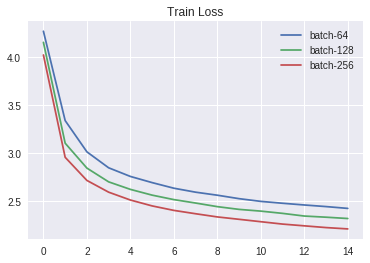

In [0]:
import matplotlib.pyplot as plt

x = np.arange(0,15)

plt.plot(x, training_loss, label='batch-64')
plt.plot(x, training_loss1,label='batch-128')
plt.plot(x, training_loss2, label='batch-256')
plt.legend()
plt.title('Train Loss')
plt.show()

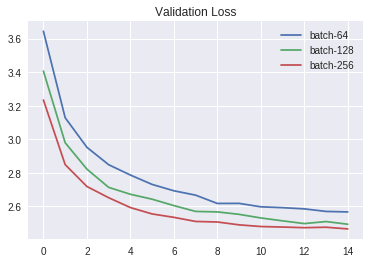

In [0]:
plt.plot(x, validation_loss, label='batch-64')
plt.plot(x, validation_loss1,label='batch-128')
plt.plot(x, validation_loss2, label='batch-256')
plt.legend()
plt.title('Validation Loss')
plt.show()

According to these graphs, increasing of batch size improves the learning efficiency of alghorithm, but the process of learning become more time consuming